<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разделение-выборок" data-toc-modified-id="Разделение-выборок-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение выборок</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Деревянные-модели" data-toc-modified-id="Деревянные-модели-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Деревянные модели</a></span></li><li><span><a href="#Деревянные-модели-на-градиентном-бустинге" data-toc-modified-id="Деревянные-модели-на-градиентном-бустинге-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Деревянные модели на градиентном бустинге</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Необходимо проанализировать исторические данные о заказах такси в аэропортах и на этой основе спрогнозировать количество заказов такси на следующий час

## Подготовка

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [7]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoost, Pool, CatBoostRegressor

In [8]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


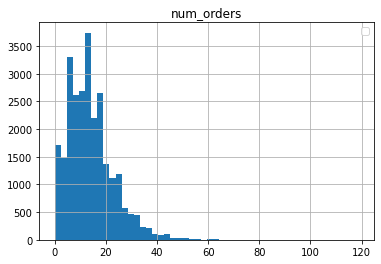

In [9]:
df.hist(bins = 50);
plt.legend();

Распределение правостороннее, близкое к Гауссову, что ожидаемо, поскольку имеем дело с событиями

In [10]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


есть ощущение, что 119 заказов это слишком много...

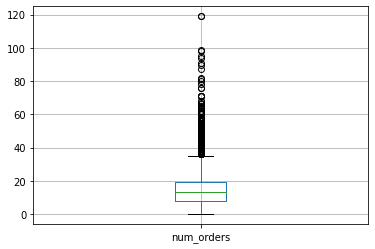

In [11]:
df.boxplot();

похоже, что всё, что больше 38 это выбросы. Избавимся от них

In [12]:
df = df.query('num_orders < 38')

In [13]:
df.duplicated().sum()

25929

Повторение значений num_orders это нормально, поскольку их всего 38 уникальных

In [14]:
df.isna().sum()

num_orders    0
dtype: int64

Пропусков нет

In [15]:
# проверим в хронологическом ли порядке расположены даты и время

print(df.index.is_monotonic)

True


всё в порядке, данные монотонны

In [16]:
# перемасштабирование данных

df.resample('1H').sum()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

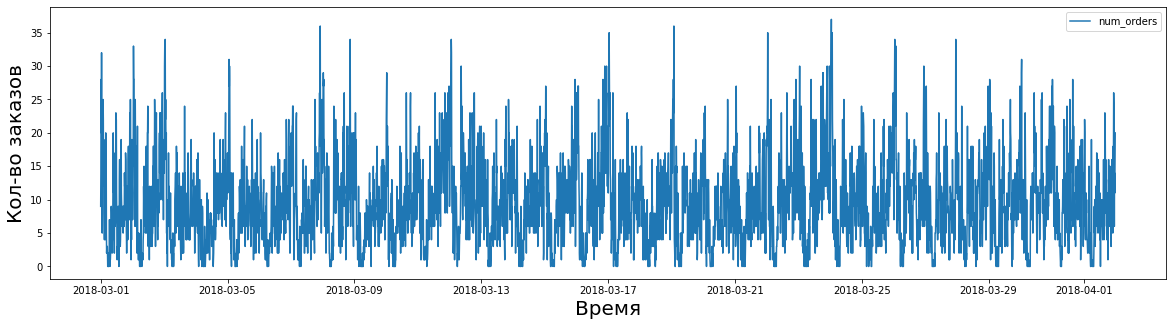

In [17]:
fig, ax = plt.subplots(figsize=(20, 5))

p = sns.lineplot(data = df['2018-03-01':'2018-04-01']);
p.set_xlabel("Время", fontsize = 20);
p.set_ylabel("Кол-во заказов", fontsize = 20);

Похоже, тут есть какая-то сезонность... Построим скользящее среднее и посмотрим только на один  месяц

In [18]:
df_rolling = df.rolling(7).mean()

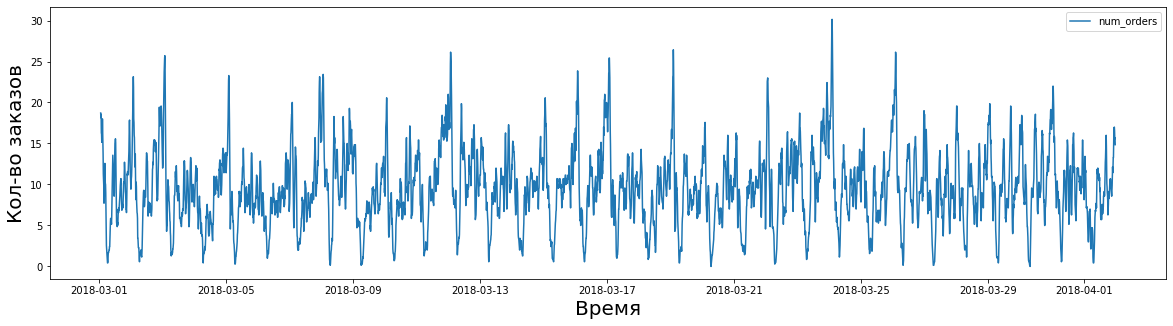

In [19]:
fig, ax = plt.subplots(figsize=(20, 5))

p = sns.lineplot(data = df_rolling['2018-03-01':'2018-04-01']);
p.set_xlabel("Время", fontsize = 20);
p.set_ylabel("Кол-во заказов", fontsize = 20);

действительно, сезонность имеется. Вычленим тренд и взглянем на сезонность отдельно

In [20]:
decomposed = seasonal_decompose(df, period = 60*24)

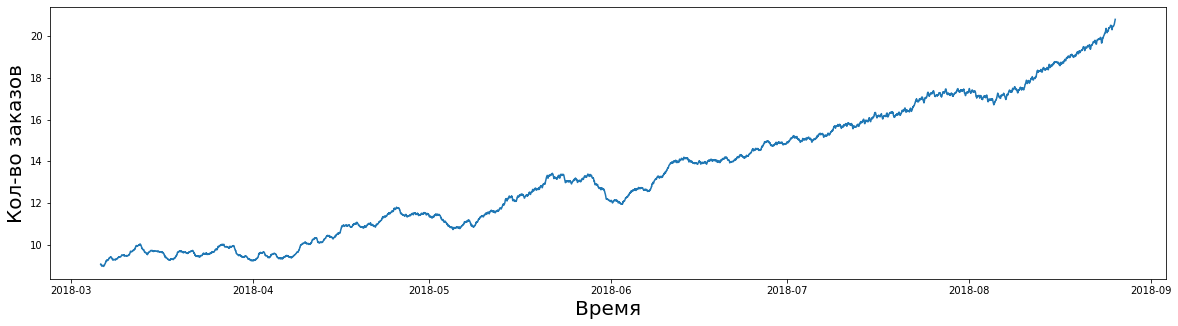

In [21]:
fig, ax = plt.subplots(figsize=(20, 5))

p = sns.lineplot(data = decomposed.trend);
p.set_xlabel("Время", fontsize = 20);
p.set_ylabel("Кол-во заказов", fontsize = 20);

Дела идут явно в гору

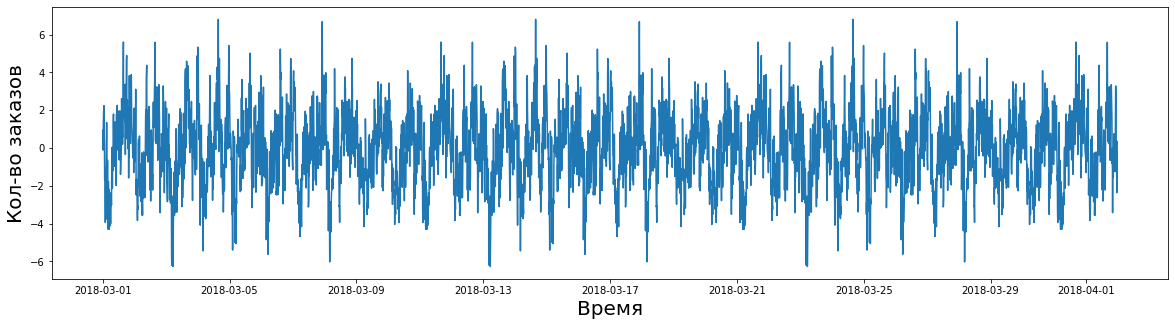

In [22]:
fig, ax = plt.subplots(figsize=(20, 5))


p = sns.lineplot(data = decomposed.seasonal['2018-03-01':'2018-04-01']);
p.set_xlabel("Время", fontsize = 20);
p.set_ylabel("Кол-во заказов", fontsize = 20);

Похоже на ритм сердца здорового человека - часы пик вверху, практически полное отсутствие заказов в непопулярное, возможно, ночное, время. Изучим это предположение, построив суточный график

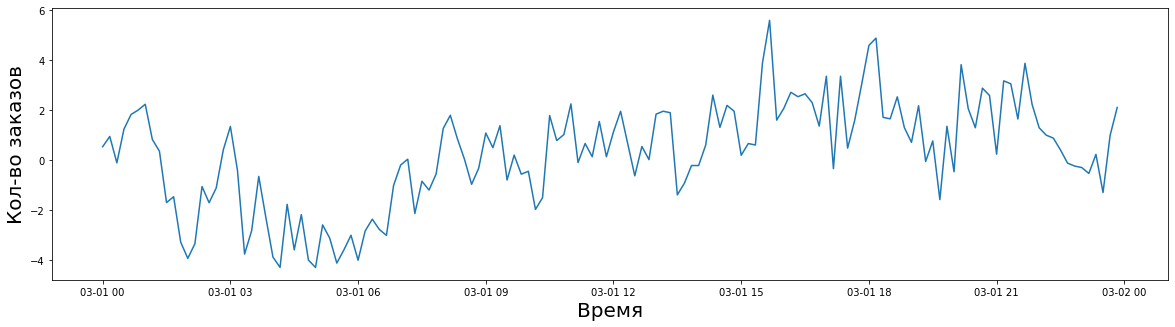

In [23]:
fig, ax = plt.subplots(figsize=(20, 5))

p = sns.lineplot(data = decomposed.seasonal['2018-03-01':'2018-03-01'])
p.set_xlabel("Время", fontsize = 20);
p.set_ylabel("Кол-во заказов", fontsize = 20);

С трёх утра до шести активность минимальна. Потом она возрастает до пиковых значений в 16-18 часов и далее постепенно спадает к ночи. Получается, что действительно, сезонность связана с суточными колебаниями ритма большого города

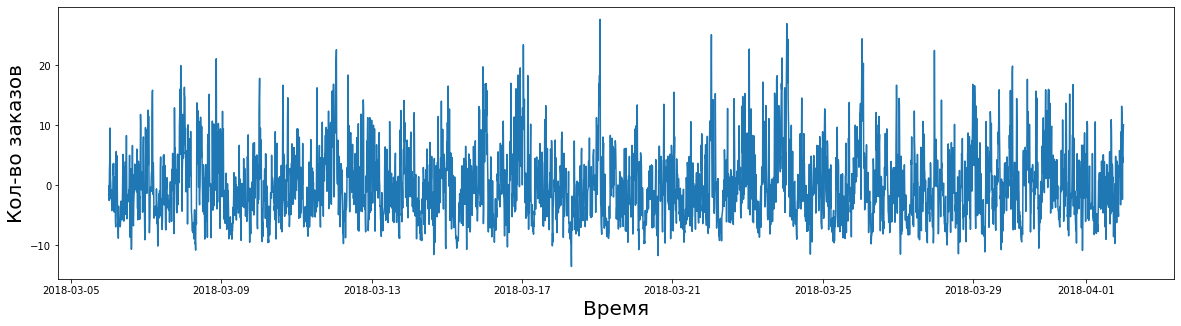

In [24]:
fig, ax = plt.subplots(figsize=(20, 5))

p = sns.lineplot(data = decomposed.resid['2018-03-01':'2018-04-01'])
p.set_xlabel("Время", fontsize = 20);
p.set_ylabel("Кол-во заказов", fontsize = 20);

шум

## Обучение

### Создание признаков

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    df['day'] = data.index.day
    df['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [26]:
make_features(df, 4, 4)

In [27]:
df.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,9,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 00:10:00,14,1,3,9.0,NaN,NaN,NaN,NaN
2018-03-01 00:20:00,28,1,3,14.0,9.0,NaN,NaN,NaN
2018-03-01 00:30:00,20,1,3,28.0,14.0,9.0,NaN,NaN
2018-03-01 00:40:00,32,1,3,20.0,28.0,14.0,9.0,17.75


### Разделение выборок

In [28]:
train, test = train_test_split(df, shuffle=False, test_size=0.1) # shuffle = False - чтобы не происходила перетасовка, поскольку для временных раядов в каждом сплите тестовые индексы должны быть позже по времени, чем обучающие
train = train.dropna()

features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

print('train_size:', features_train.shape)
print('test_size:', features_test.shape)

train_size: (23366, 7)
test_size: (2597, 7)


### Линейная регрессия

In [30]:
model = LinearRegression()
model.fit(features_train, target_train)

print("RMSE обучающей выборки:", mean_squared_error(model.predict(features_train), target_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(model.predict(features_test), target_test)**0.5)

RMSE обучающей выборки: 5.426588591428658
RMSE тестовой выборки:  6.7023915503051406


Модель линейной регрессии показала достаточно малую ошибку RMSE

### Деревянные модели

In [31]:
tscv = TimeSeriesSplit(n_splits=4)
rmse = []

for train_index, valid_index in tscv.split(train):
    cv_train, cv_valid = train.iloc[train_index], train.iloc[valid_index]
    
    features_train_cv = cv_train.drop('num_orders', axis = 1)
    target_train_cv = cv_train['num_orders']
    
    features_valid_cv = cv_valid.drop('num_orders', axis = 1)
    target_valid_cv = cv_valid['num_orders']

In [32]:
def algorithm_pipeline(features_train_data, features_test_data, target_train_data, target_test_data, 
                       model, param_grid, num_splits = 4,
                       scoring_fit='neg_mean_squared_error', do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=TimeSeriesSplit(n_splits=num_splits).split(features_train_data), # TimeSeriesSplit используется для временных рядов
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(features_train_data, target_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(features_test_data)
    else:
        pred = fitted_model.predict(features_test_data)
    
    return fitted_model, pred

In [33]:
%%time

DT_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': list(range(1,11))
}

DT_model, pred = algorithm_pipeline(features_train_cv, features_valid_cv, target_train_cv, target_valid_cv, DT_model, 
                                 param_grid)

print(np.sqrt(-DT_model.best_score_))
print(DT_model.best_params_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
5.357647421264179
{'max_depth': 4}
CPU times: user 238 ms, sys: 110 ms, total: 348 ms
Wall time: 2.62 s


Модель дерева решений сработала достаточно быстро и показала результат лучше, чем модель линейной регрессии

In [34]:
%%time

RF_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
}

RF_model, pred = algorithm_pipeline(features_train_cv, features_valid_cv, target_train_cv, target_valid_cv, RF_model, 
                                 param_grid)

print(np.sqrt(-RF_model.best_score_))
print(RF_model.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
5.311709334639047
{'max_depth': 5, 'n_estimators': 100}
CPU times: user 1.88 s, sys: 30.8 ms, total: 1.91 s
Wall time: 13.8 s


Модель случайного леса работала несколько дольше модели дерева решений, но и результат показала лучше.

### Деревянные модели на градиентном бустинге

In [39]:
%%time

lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_test, target_test, reference=lgb_train)

param_grid = {
    "max_depth": [5, 10],
    "num_leaves": [10, 20]  
}

gbm_cv = lgb.LGBMRegressor()

gbm_cv, pred = algorithm_pipeline(features_train_cv, features_valid_cv, target_train_cv, target_valid_cv, gbm_cv, 
                                 param_grid)

print(np.sqrt(-gbm_cv.best_score_))
print(gbm_cv.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
5.337249156438971
{'max_depth': 5, 'num_leaves': 10}
CPU times: user 263 ms, sys: 53.3 ms, total: 316 ms
Wall time: 3.72 s


Модель дерева решений на градиентном бустинге LGBM работала дольше в сравнении с моделью sklearn, а результат показала хуже

In [40]:
%%time

xgb_model = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
}

xgb_model, pred = algorithm_pipeline(features_train_cv, features_valid_cv, target_train_cv, target_valid_cv, xgb_model, 
                                 param_grid)

print(np.sqrt(-xgb_model.best_score_))
print(xgb_model.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[11:38:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5.379006219133564
{'max_depth': 5, 'n_estimators': 50}
CPU times: user 751 ms, sys: 26.5 ms, total: 778 ms
Wall time: 11 s


Модель случайного леса на градиентном бустинге XGB работала очень долго, а результат показала достаточно плохой

In [41]:
%%time

CBM = CatBoostRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
}

CBM, pred = algorithm_pipeline(features_train_cv, features_valid_cv, target_train_cv, target_valid_cv, CBM, 
                                 param_grid)

print(np.sqrt(-CBM.best_score_))
print(CBM.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Learning rate set to 0.5
0:	learn: 5.8703813	total: 3.34ms	remaining: 164ms
1:	learn: 5.4114133	total: 6.15ms	remaining: 148ms
2:	learn: 5.2771782	total: 8.99ms	remaining: 141ms
3:	learn: 5.2187158	total: 12ms	remaining: 138ms
4:	learn: 5.1985981	total: 14.9ms	remaining: 134ms
5:	learn: 5.1866793	total: 17.9ms	remaining: 131ms
6:	learn: 5.1790348	total: 20.7ms	remaining: 127ms
7:	learn: 5.1706622	total: 23.4ms	remaining: 123ms
8:	learn: 5.1602626	total: 26.4ms	remaining: 120ms
9:	learn: 5.1539334	total: 29ms	remaining: 116ms
10:	learn: 5.1490779	total: 31.9ms	remaining: 113ms
11:	learn: 5.1457138	total: 34.6ms	remaining: 110ms
12:	learn: 5.1387469	total: 37.3ms	remaining: 106ms
13:	learn: 5.1350831	total: 40.1ms	remaining: 103ms
14:	learn: 5.1309630	total: 42.7ms	remaining: 99.7ms
15:	learn: 5.1251299	total: 45.3ms	remaining: 96.4ms
16:	learn: 5.1216407	total: 48.1ms	remaining: 93.3ms
17:	learn: 5.1173795	total: 50.9ms	remaini

Модель случайного леса на градиентном бустинге CatBoost работала достаточно быстро, показала результат лучше, чем у других моделей на градиентном бустинге, но ошибка всё же больше, чем у модели дерева решений sklearn

In [42]:
print('DT_model RMSE:', np.sqrt(-DT_model.best_score_))
print(DT_model.best_params_)
print('')
print('RF_model RMSE:', np.sqrt(-RF_model.best_score_))
print(RF_model.best_params_)
print('')
print('gbm_cv RMSE:', np.sqrt(-gbm_cv.best_score_))
print(gbm_cv.best_params_)
print('')
print('xgb_model RMSE:', np.sqrt(-xgb_model.best_score_))
print(xgb_model.best_params_)
print('')
print('CBM RMSE:', np.sqrt(-CBM.best_score_))
print(CBM.best_params_)

DT_model RMSE: 5.357647421264179
{'max_depth': 4}

RF_model RMSE: 5.311709334639047
{'max_depth': 5, 'n_estimators': 100}

gbm_cv RMSE: 5.337249156438971
{'max_depth': 5, 'num_leaves': 10}

xgb_model RMSE: 5.379006219133564
{'max_depth': 5, 'n_estimators': 50}

CBM RMSE: 5.451596355941187
{'max_depth': 5, 'n_estimators': 50}


Вывод: наилучший результат показала модель случайного леса. 

## Тестирование

In [43]:
DT_model = DecisionTreeRegressor(max_depth = 4)
DT_model.fit(features_train, target_train)
predictions = DT_model.predict(features_test)

print(mean_squared_error(target_test, predictions) ** 0.5)

6.911034436802054


Вывод: наименьшую ошибку имеет модель дерева решений с параметром max_depth = 4. При таком гиперпараметре на тестовой выборке метрика RMSE составляет 6.9